This post describes an attempt at reproducing a [study of ocean color optical water types (OWT)](http://ieeexplore.ieee.org/document/942555/). Here, remote sensing reflectance (Rrs) was used to partition samples into one of several water types according to their [apparent optical properties](https://en.wikipedia.org/wiki/Water_remote_sensing). Naturally, the assumption is that the data set at hand - over 2400 samples including latitude, longitude, 12 bands in the visible spectrum, and chlorophyll. 
The authors of the study referred to above used fuzzy c-means clustering (FCM). However, [K-means clustering yields results that are pretty close to FCM](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.403.7600&rep=rep1&type=pdf). So that's what I'll use here. 
<!-- TEASER_END -->

In [1]:
import os
from scipy.io import loadmat as LM
import matplotlib.pyplot as pl
from matplotlib.colors import BoundaryNorm as BN
from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm
from matplotlib import rcParams
import seaborn as SB
import pandas as PD
import numpy as NP
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important;}</style>"))
%matplotlib inline
%precision 3

'%.3f'

Additional graphic settings

In [2]:
rcParams['axes.formatter.limits']=(-2,3)
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams['font.size'] = 16

In [3]:
# Specifying data file paths
maindir = '/home/madhatter106/DATA/OceanColor/OWT/'
fname = 'nomad_rrs4clustering.mat'
fpath = os.path.join(maindir,fname)

This is a MATLAB data file, so I'll use scipy's loadmat method to load a MATLAB namespace into a python dictionary.

In [4]:
matlabData = LM(fpath)

Taking a look at the dictionary keys...

In [5]:
matlabData.keys()

dict_keys(['__header__', 'lat_nomad', '__version__', 'rrs_below', '__globals__', 'chl_nomad', 'lon_nomad', 'wl'])

Dictionary keys are:
* wl: wavelength
* lat_nomad: latitude
* lon_nomad: longitude
* chl_nomad: chlorophyll *a*
* rrs_below: sub-surface 

I'll assign the data to separate containers.

In [6]:
wavelength = matlabData['wl']
lat = matlabData['lat_nomad']
lon = matlabData['lon_nomad']
rrsBelow = matlabData['rrs_below']
chl = matlabData['chl_nomad'] # I might use this as an additional feature in clustering

In [7]:
geoLbl = ['lat', 'lon']
wlLbl = list(wavelength[0])
prodLbl = ['chl']
labels = geoLbl + wlLbl + prodLbl
df = PD.DataFrame(data=NP.hstack((lat,lon,rrsBelow,chl)), columns=labels)

Let's take a look at the first few lines of the dataframe

In [8]:
df.describe()

,lat,lon,411,443,469,489,510,520,547,550,555,560,565,670,chl
count,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000
mean,21.481930,-64.103323,0.009913,0.009351,0.009408,0.009086,0.007638,0.007200,0.006301,0.006246,0.006105,0.005999,0.005913,0.001289,1.544312
std,30.793904,62.277488,0.006548,0.005329,0.005020,0.004598,0.004656,0.004964,0.005866,0.005977,0.006091,0.006254,0.006359,0.002629,4.002408
min,-76.633000,-179.955000,0.000098,0.000365,0.000429,0.000546,0.000502,0.000463,0.000404,0.000410,0.000398,0.000374,0.000362,0.000023,0.000000
25%,22.893175,-118.275500,0.005000,0.005335,0.005714,0.006135,0.005511,0.004927,0.003390,0.003257,0.003029,0.002801,0.002599,0.000196,0.054000
50%,31.792500,-75.494750,0.007967,0.008120,0.008610,0.008528,0.006562,0.005780,0.004292,0.004185,0.003970,0.003761,0.003624,0.000385,0.301200
75%,36.829250,-54.195000,0.013895,0.012699,0.012526,0.011118,0.007965,0.007237,0.006257,0.006207,0.006047,0.005934,0.005880,0.001101,1.218750
max,79.000000,179.907000,0.039485,0.031489,0.042271,0.046573,0.050136,0.051616,0.057989,0.059072,0.060087,0.061543,0.062095,0.031832,72.120000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2404 entries, 0 to 2403
Data columns (total 15 columns):
lat    2404 non-null float64
lon    2404 non-null float64
411    2404 non-null float64
443    2404 non-null float64
469    2404 non-null float64
489    2404 non-null float64
510    2404 non-null float64
520    2404 non-null float64
547    2404 non-null float64
550    2404 non-null float64
555    2404 non-null float64
560    2404 non-null float64
565    2404 non-null float64
670    2404 non-null float64
chl    2404 non-null float64
dtypes: float64(15)
memory usage: 281.8 KB


The table above shows that there are no missing data. I'll take a more thorough look at the data further below. For now, and for context, and since geolocation is provided, I'll map these data to get a sense of their spatial distribution around the glob. It would be desirable to have data from a wide variety of marine environments.

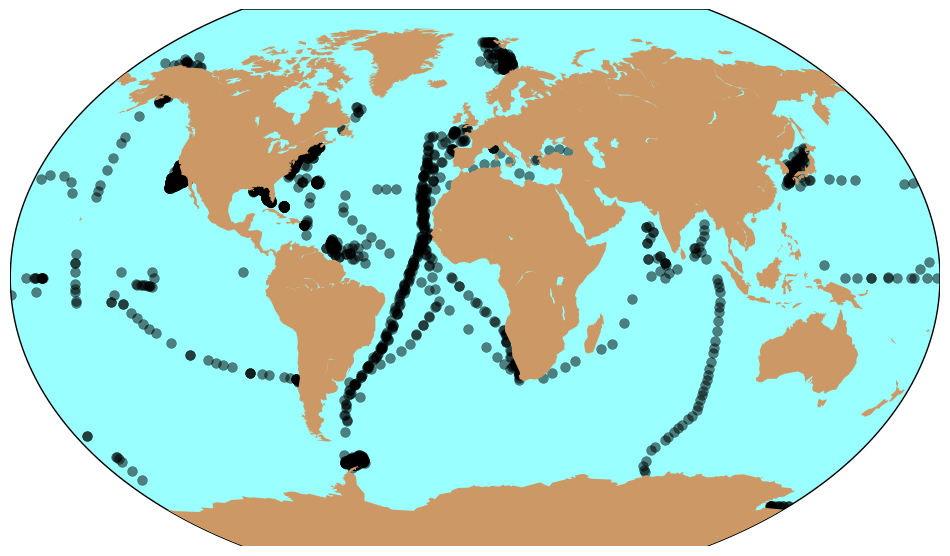

In [10]:
fig,ax=pl.subplots(figsize=(12,10))
m = Basemap(projection='kav7',lon_0=0,ax=ax)
x,y=m(df.lon.values,df.lat.values)
m.drawmapboundary(fill_color='#99ffff')
m.fillcontinents(color='#cc9966',lake_color='#99ffff')
m.scatter(x,y,50,marker='o',color='k',alpha=0.5);

Note that the darker groupings show greater sample density. The map above shows that some environments tend to be sampled more often than others.
As mentioned earlier, I want to plot the data to get a feel for it. I also want to have a sense of how  each feature relates to the others. Seaborn's pairplot method is quite handy for this. In the figure below I only plot Rrs data, as that is what I will use for the clustering part. The main diagonal displays each feature's distribution, while the lower (or upper) triangle depicts feature-to-feature relation.

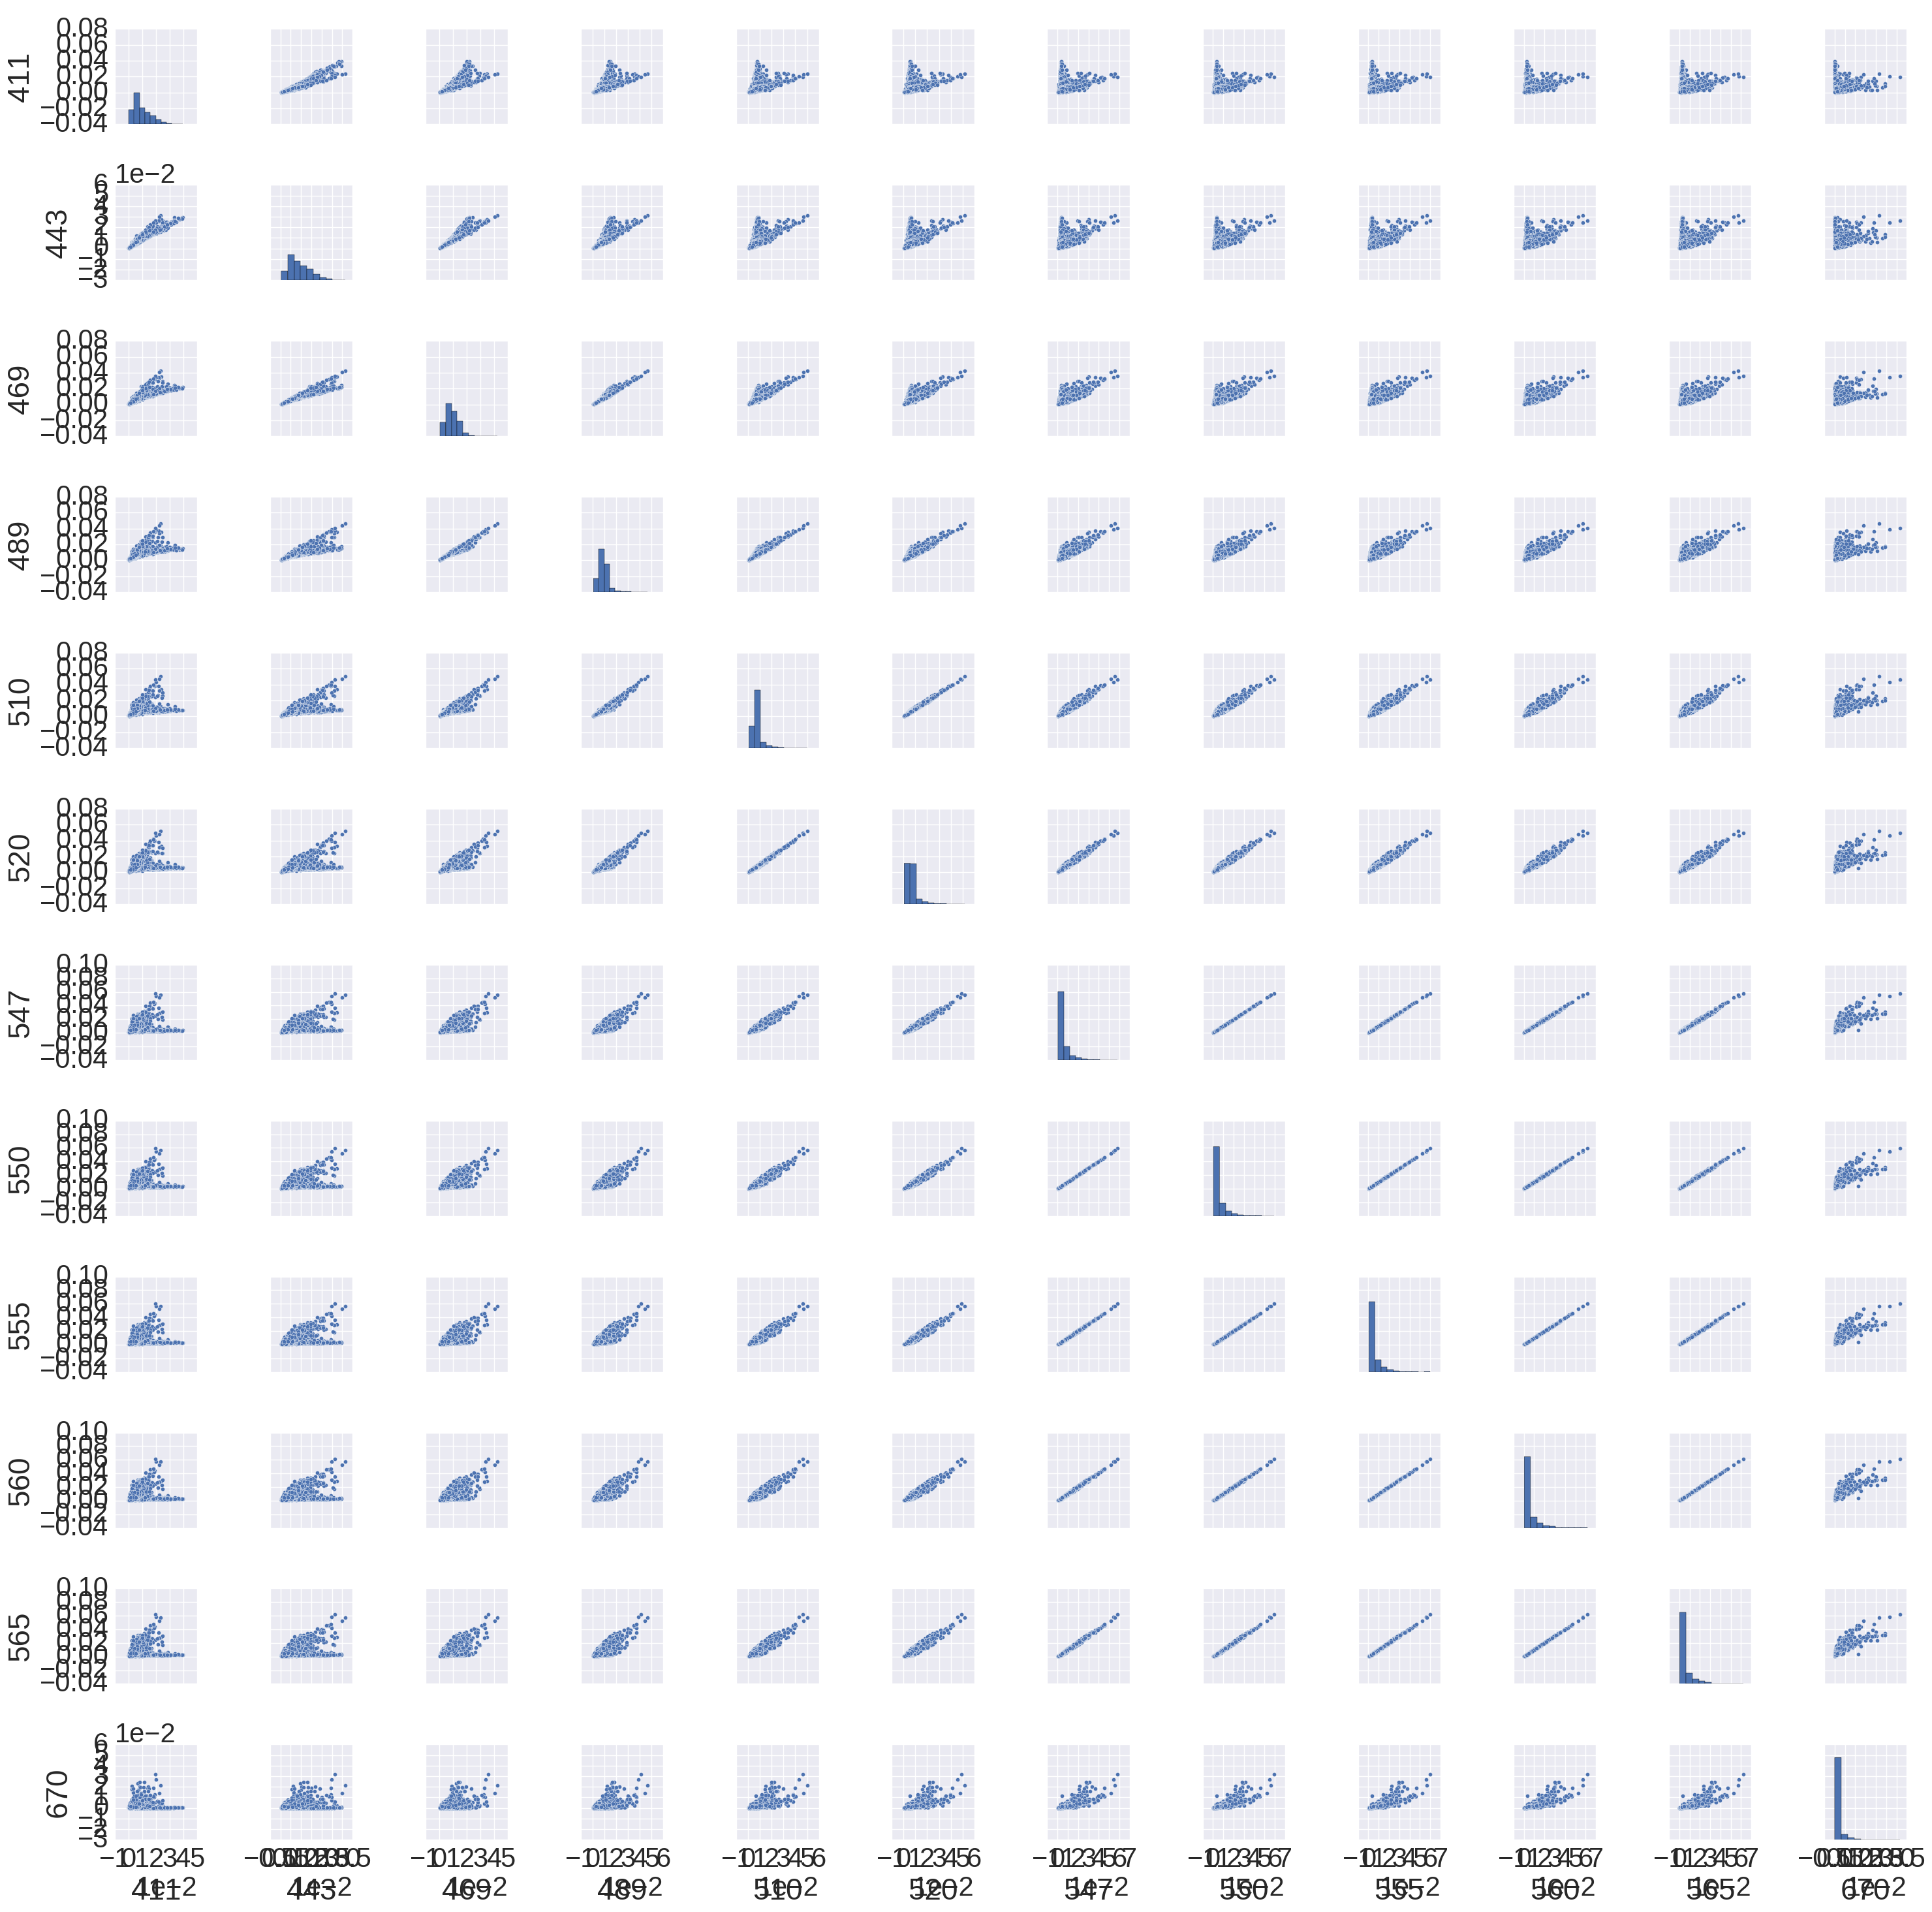

In [11]:
SB.set(context='notebook',font_scale=3)
SB.pairplot(df.loc[:,wlLbl]);

The plot above shows high correlation among some bands, mostly between those that are close to each other. Some dimension reduction appears warranted. I will first standardize the data. I will then proceed with PCA.

In [12]:
sc = StandardScaler()
dataStd = sc.fit_transform(df.loc[:,wlLbl].values)
dfStd = PD.DataFrame(dataStd,columns=wlLbl)

Now to make sure that this had the desired effect (mean~0, stdev~1)

In [13]:
dfStd.describe()

,411,443,469,489,510,520,547,550,555,560,565,670
count,2.404000e+03,2.404000e+03,2.404000e+03,2.404000e+03,2.404000e+03,2.404000e+03,2.404000e+03,2.404000e+03,2.404000e+03,2.404000e+03,2.404000e+03,2.404000e+03
mean,1.108376e-16,-5.338676e-17,-1.560962e-17,8.913188e-17,-4.858380e-17,-1.423339e-16,-5.625007e-17,-4.733688e-17,1.763010e-16,3.183925e-16,5.384859e-17,-3.461365e-17
std,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00
min,-1.499165e+00,-1.686430e+00,-1.788811e+00,-1.857760e+00,-1.533065e+00,-1.357243e+00,-1.005421e+00,-9.765209e-01,-9.370233e-01,-8.996961e-01,-8.731992e-01,-4.819356e-01
25%,-7.504352e-01,-7.537173e-01,-7.359950e-01,-6.419132e-01,-4.568864e-01,-4.578923e-01,-4.962801e-01,-5.001160e-01,-5.049955e-01,-5.113855e-01,-5.211910e-01,-4.158278e-01
50%,-2.972898e-01,-2.310136e-01,-1.589268e-01,-1.214855e-01,-2.310029e-01,-2.861123e-01,-3.424316e-01,-3.448293e-01,-3.506027e-01,-3.578891e-01,-3.600168e-01,-3.440910e-01
75%,6.081378e-01,6.284834e-01,6.212235e-01,4.419674e-01,7.039356e-02,7.483167e-03,-7.431775e-03,-6.504881e-03,-9.454504e-03,-1.038570e-02,-5.095303e-03,-7.148734e-02
max,4.516979e+00,4.154953e+00,6.547083e+00,8.154232e+00,9.130229e+00,8.948706e+00,8.812843e+00,8.839424e+00,8.864605e+00,8.883801e+00,8.837111e+00,1.162061e+01


In [14]:
def PlotPCARes(classifier, data, threshold=0.85):
    """This function plots PCA results"""
    f,ax = pl.subplots(ncols=2,figsize=(12,6))
    n = data.shape[1]
    ax[0].bar(range(1, n+1),classifier.explained_variance_ratio_, align='center', color='skyblue');
    ax[0].step(range(1, n+1),NP.cumsum(classifier.explained_variance_ratio_), where='mid')
    ax[0].hlines(threshold, 0, n+2, linestyles='--', linewidth=2, label='feature selection cutoff')
    ax[0].set_xticks(NP.arange(1,n+1))
    ax[0].set_xticklabels(['PC%d' %i for i in range(1,n+1)],rotation=45)
    ax[0].set_xlim((0,1+n))
    ax[0].set_ylim((0,1))
    ax[0].set_title('PCA Summary')
    ax[0].legend(loc='best')
    ax[1].set_title('First Two PCs')
    ax[1].scatter(data[:,0], data[:,1], alpha=0.1,edgecolor='k', linewidth=2);
    ax[1].set_xlabel('PC1')
    ax[1].set_ylabel('PC2')

Now I'm going to instantiate a pca object from scikit-learns' PCA class

In [15]:
pca = PCA()
pcData = pca.fit_transform(dataStd)

Next, I print the explained variance for each principal component (PC). Note that sklearn has already sorted them accordingly in descending order.

In [16]:
print("explained variance, by PC")
print(pca.explained_variance_)
print('-' * 80)
print("relative explained variance by PC")
print(pca.explained_variance_ratio_)

explained variance, by PC
[  8.407e+00   3.156e+00   3.421e-01   7.284e-02   1.521e-02   7.102e-03
   9.632e-05   9.498e-06   4.484e-07   3.007e-08   9.720e-10   2.209e-10]
--------------------------------------------------------------------------------
relative explained variance by PC
[  7.006e-01   2.630e-01   2.851e-02   6.070e-03   1.267e-03   5.919e-04
   8.027e-06   7.915e-07   3.737e-08   2.506e-09   8.100e-11   1.841e-11]


I'm going to use a cumulative 90%  in relative explained variance to determine the principal components that I will use for clustering. The first two clusters account for 96% so I'll use PC1 and PC2. Here's a graphical rendering of PCs with the decision boundary, and a scatter plot of the first two components.

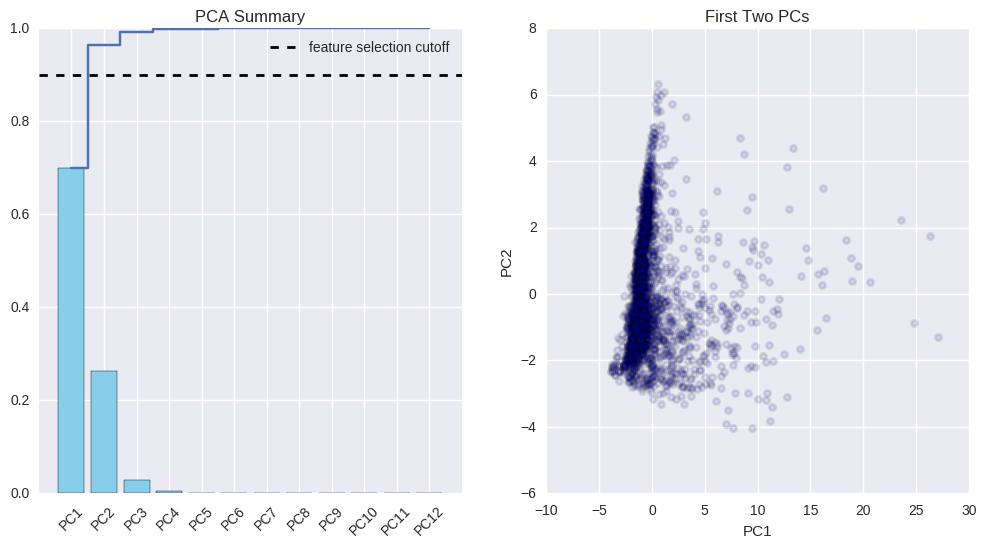

In [17]:
SB.set(context='notebook',font_scale=1)
PlotPCARes(pca, pcData, threshold=0.9)
SB.set_style(rc=rcParams)

The data resulting from PCA is no longer standardized. I will therefore standardize the first two PCs before passing them to the KMeans algorithm.

In [18]:
sc2 = StandardScaler()
pcFirst2Std = sc2.fit_transform(pcData[:,:2])

Next is a bit of a long-winded code bit that goes through a number of cluster numbers, with corresponding figures featuring silhouette plots on the left data color-coded by cluster membership, along with cluster centroids. I'll also store silhouette scores and within cluster sum of squares.  The former detailing how distinct any given point is from the closest centroid it is not a member of; the latter describing how compact each cluster is. Note that while I explore 2-20 cluster fitting, I'm only plotting up to 8 clusters to avoid unnecessary clutter, as it turns out the best results are among these.

Quite a bit the code below was lifted from [here](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py). 

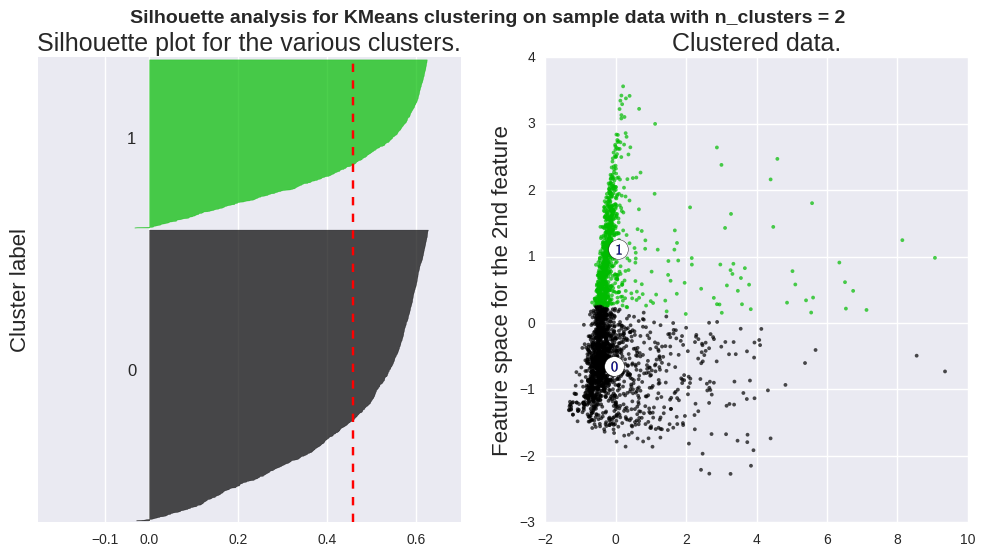

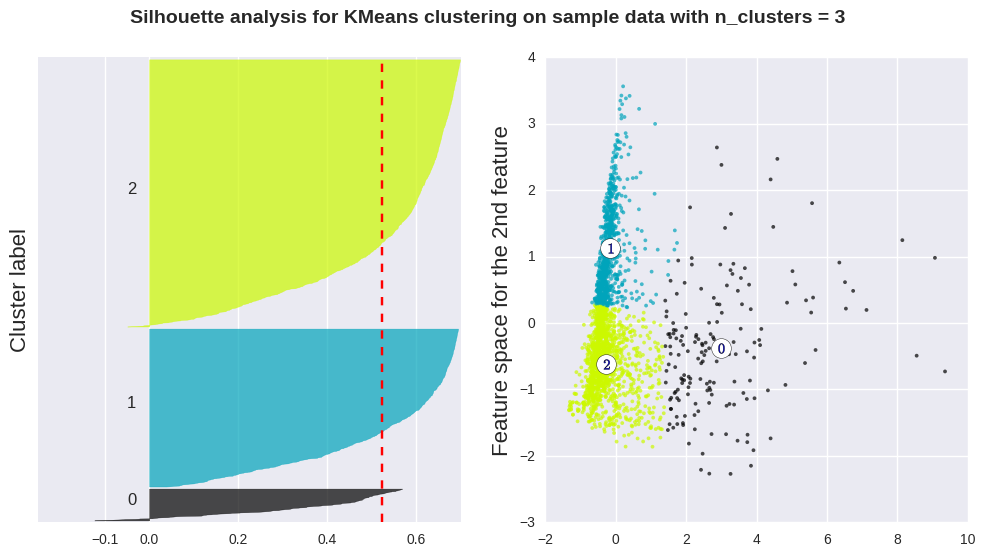

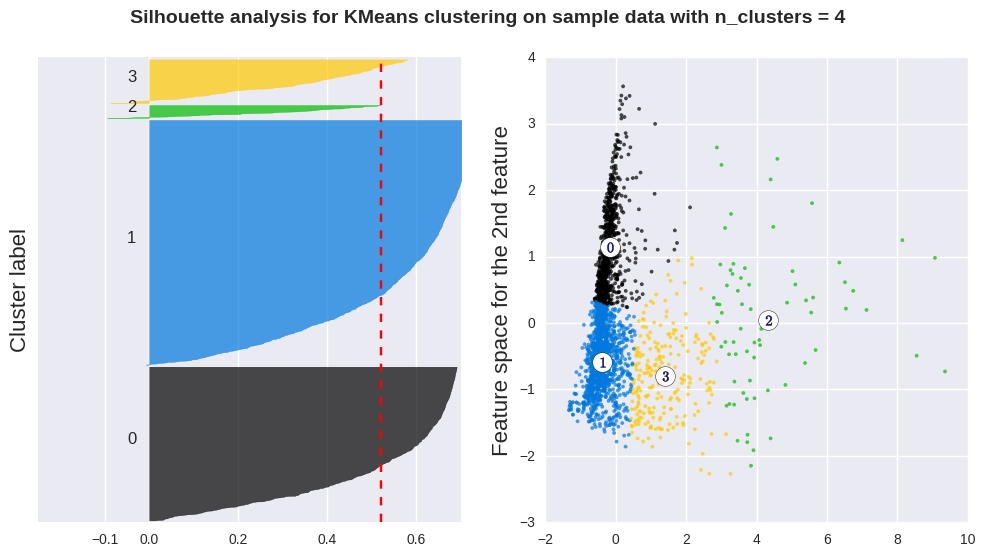

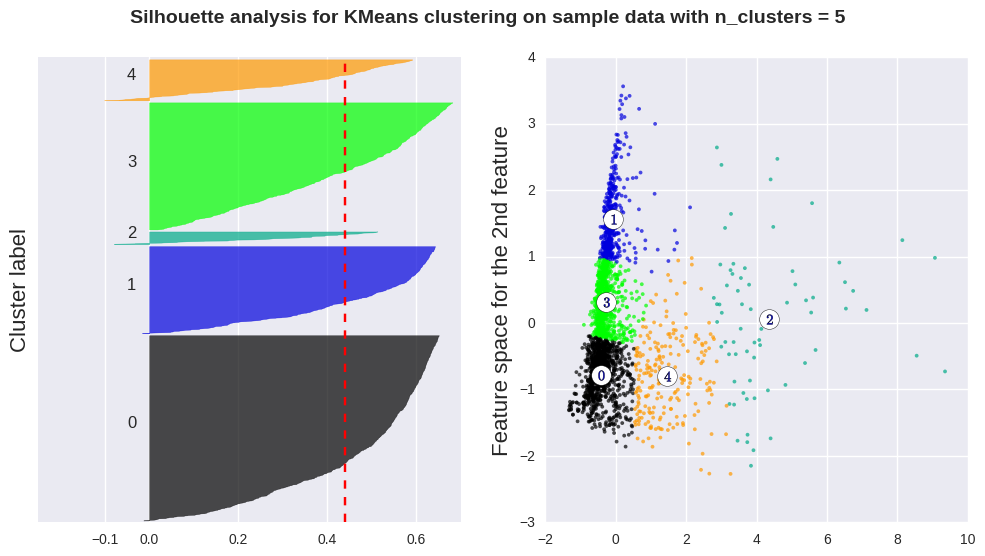

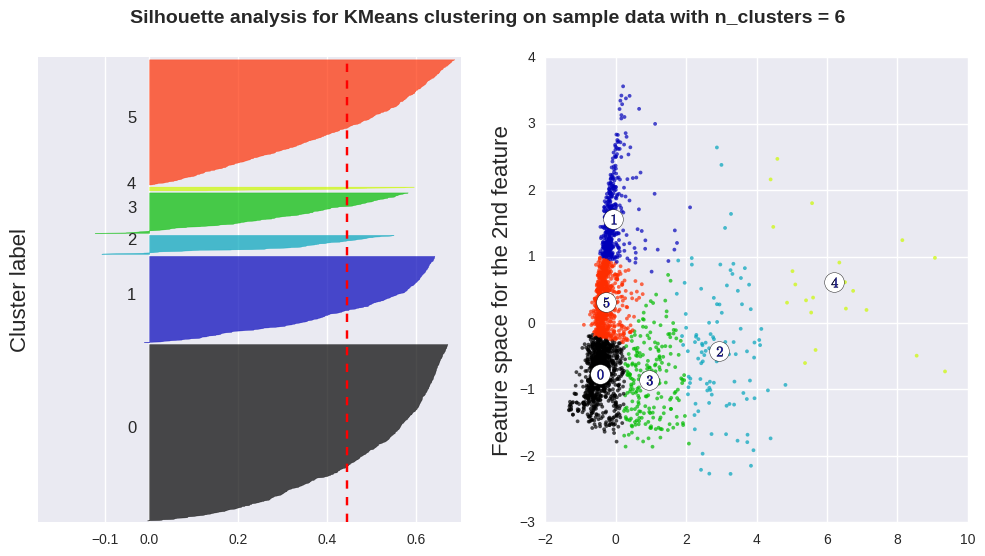

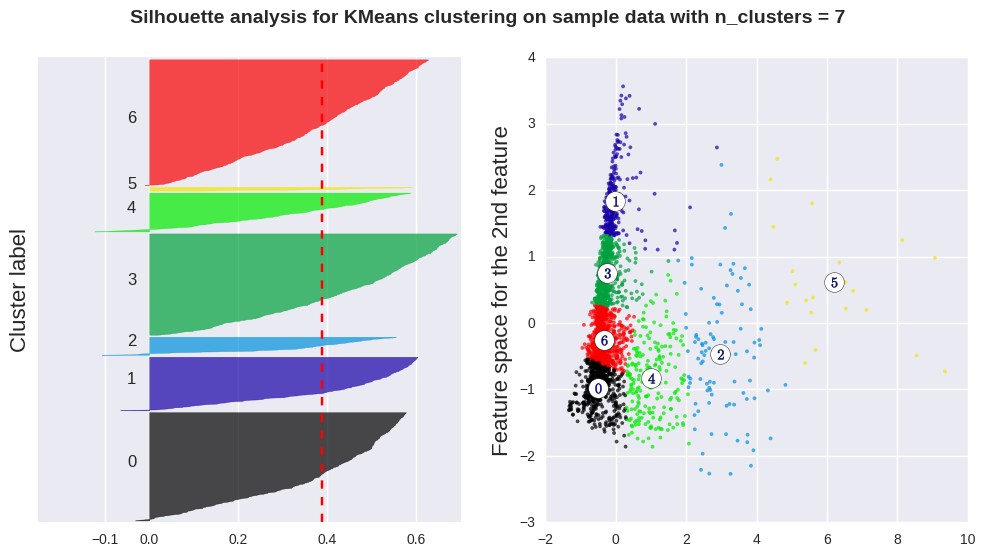

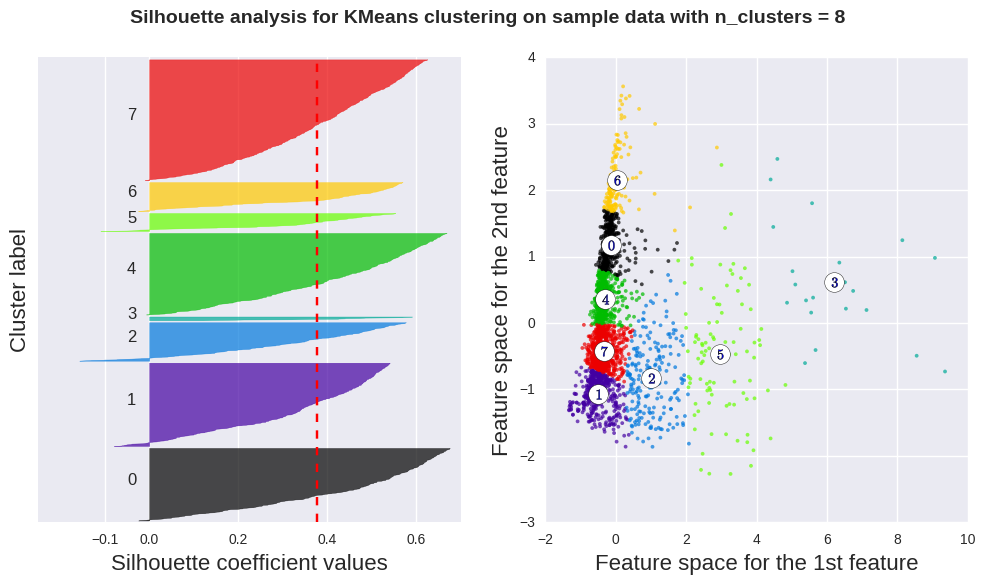

In [19]:
wInClustSumSq = []
silScore = []
centroids = []
maxClust = 20
maxPlotClust = 8
for iClust in range(2,maxClust+1):
    
    km = KMeans(n_clusters=iClust, init='k-means++', n_init=10, max_iter=500, random_state=0, n_jobs=-1)
    km.fit(pcFirst2Std)
    labels=km.labels_
    wInClustSumSq.append(km.inertia_)
    silScore.append(silhouette_score(pcFirst2Std, labels, metric='euclidean'))
    centroids.append(km.cluster_centers_)
    sample_silhouette_values = silhouette_samples(pcFirst2Std, labels)
    silhouette_avg = silhouette_score(pcFirst2Std, labels)
    if iClust <= maxPlotClust:
        f,axs = pl.subplots(ncols=2,figsize=(12,6))
        # silhouette scores range from -1 to 1, but in this case the range is (0.25 to 0.65)

        axs[0].set_ylim([0, len(pcFirst2Std) + (iClust + 1) * 10]) # this to 
        y_lower = 10
        for i in range(iClust):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            color = cm.spectral(float(i) / iClust)
            axs[0].fill_betweenx(NP.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            axs[0].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples
        if iClust == 2:
            axs[0].set_title("Silhouette plot for the various clusters.",
                            fontsize=18)
            axs[1].set_title("Clustered data.",
                            fontsize=18)
        if iClust == maxPlotClust:
            axs[0].set_xlabel("Silhouette coefficient values",
                             fontsize=16)
            axs[1].set_xlabel("Feature space for the 1st feature",
                             fontsize=16)
        axs[0].set_ylabel("Cluster label", fontsize=16)
        axs[0].axvline(x=silhouette_avg, color="red", linestyle="--")

        axs[0].set_yticks([])  # Clear the yaxis labels / ticks
        axs[0].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        axs[0].set_xlim([-.25, .7])
        # 2nd Plot showing the actual clusters formed
        colors = cm.spectral(labels.astype(float) / iClust)
        axs[1].scatter(pcFirst2Std[:, 0], pcFirst2Std[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors)

        # Labeling the clusters
        centers = km.cluster_centers_
        # Draw white circles at cluster centers
        axs[1].scatter(centers[:, 0], centers[:, 1],
                    marker='o', c="white", alpha=1, s=200)

        for i, c in enumerate(centers):
            axs[1].scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)
        axs[1].set_ylabel("Feature space for the 2nd feature",
                         fontsize=16)

        pl.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % iClust),
                     fontsize=14, fontweight='bold')

The plots above on the left hand side are an example of silhouette analysis. Silhouette coefficients indicate how tightly packed each cluster is. Additionally the average silhouette score is plotted (here as a red dashed line). The criteria for evaluating a particular clustering scheme include the following:
* all clusters above the average silhouette score,
* clusters relatively equal in size
* as few "possibly badly clustered points" (silhouette score < 0) as possible

As can be seen in the figures above, real world data tends to be messy and the application of these criteria can be a bit fuzzy. But as long as the thought process is plainly expressed (making it debatable and revisable). No stress required.

The criteria above suggest that a 3-cluster partition works best. We can try to confirm that using the elbow method, as well as plotting the average silhouette score; both as a function of cluster number.

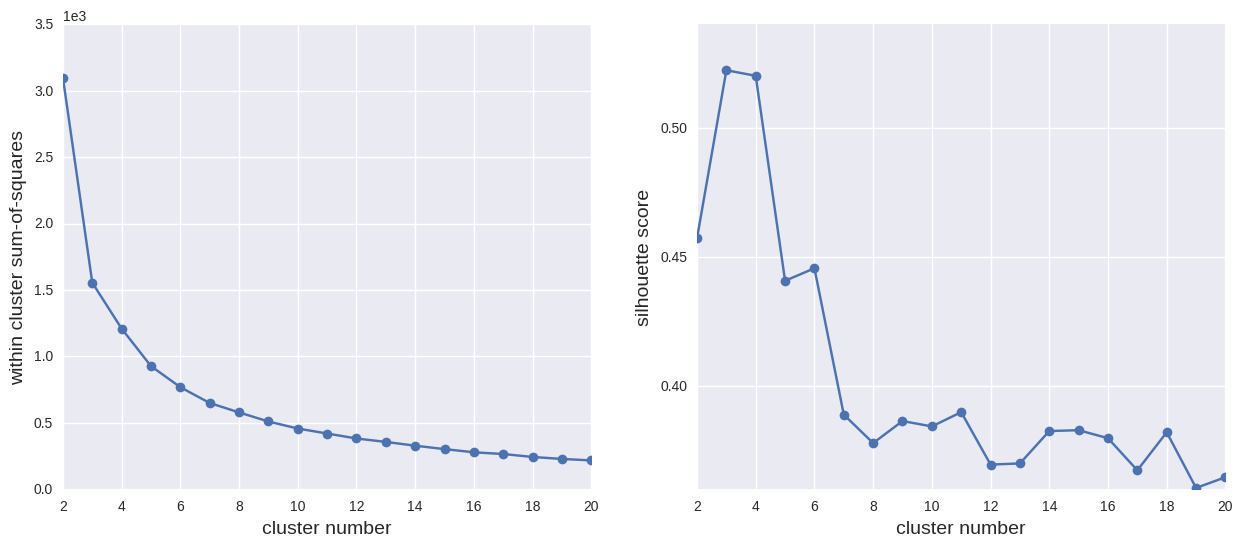

In [20]:
f,axs = pl.subplots(ncols=2,figsize=(15,6))
axs[0].plot(range(2, maxClust+1), wInClustSumSq, marker='o')
axs[0].set_xlabel('cluster number', fontsize=14)
axs[0].set_ylabel('within cluster sum-of-squares', fontsize=14);
axs[1].plot(range(2, maxClust+1), silScore, marker='o')
axs[1].set_xlabel('cluster number',fontsize=14)
axs[1].set_ylabel('silhouette score', fontsize=14);

The plots above seem to confirm the earlier diagnosis. There's an obvious elbow for a 3-cluster arrangement, which incidentally has the highest silhouette score. One might argue that there is a secondary elbow around 5-6 clusters, and there is a secondary peak around cluster 6 in the silhouette score plot. Silhouette analysis for these partitions shows disproportionate clusters. This may not necessarily discard these alternatives however, as some water types may be underrepresented depending on when/where they were sampled. I will therefore retain labels for 3-, 5- and 6-cluster partitions, to see the resulting spatial distribution on the world map above.
Note that the 4-cluster arrangement is not retained because one of the cluster is just below the corresponding average silhouette score. The next step is then to re-run KMeans thrice.

In [21]:
clusterNums = [3,5,6]
labelsDict = {}
for iclust in clusterNums:
    km = KMeans(n_clusters=iclust, init='k-means++', n_init=10, max_iter=500, random_state=0, n_jobs=-1)
    km.fit(pcFirst2Std)
    labelsDict['%d-cluster' % iclust] = km.labels_

Now I merge these labels into the original pandas dataframe.

In [22]:
dflabels=PD.DataFrame(labelsDict,columns=labelsDict.keys())
dfnew=PD.concat((df,dflabels),axis=1)
dfnew.head()

,lat,lon,411,443,469,489,510,520,547,550,555,560,565,670,chl,3-cluster,6-cluster,5-cluster
0,38.4279,-76.61,0.002307,0.003225,0.004674,0.006265,0.007661,0.008944,0.012935,0.013410,0.014040,0.014715,0.015325,0.006588,38.19,2,3,4
1,38.3680,-76.50,0.002035,0.002650,0.003273,0.004149,0.004767,0.005416,0.007338,0.007570,0.007878,0.008208,0.008549,0.003241,35.01,2,0,0
2,38.3074,-76.44,0.001862,0.002271,0.002654,0.003523,0.004367,0.005147,0.007423,0.007691,0.008053,0.008434,0.008822,0.003084,26.91,2,0,0
3,38.6367,-76.32,0.002817,0.003330,0.004096,0.005482,0.006963,0.008243,0.012075,0.012525,0.013127,0.013770,0.014361,0.006154,47.96,2,3,4
4,38.3047,-76.44,0.001735,0.001959,0.002129,0.002882,0.003638,0.004115,0.005079,0.005191,0.005337,0.005507,0.005716,0.003423,23.55,2,0,0


Next is to see whether these clusterings make graphical sense...

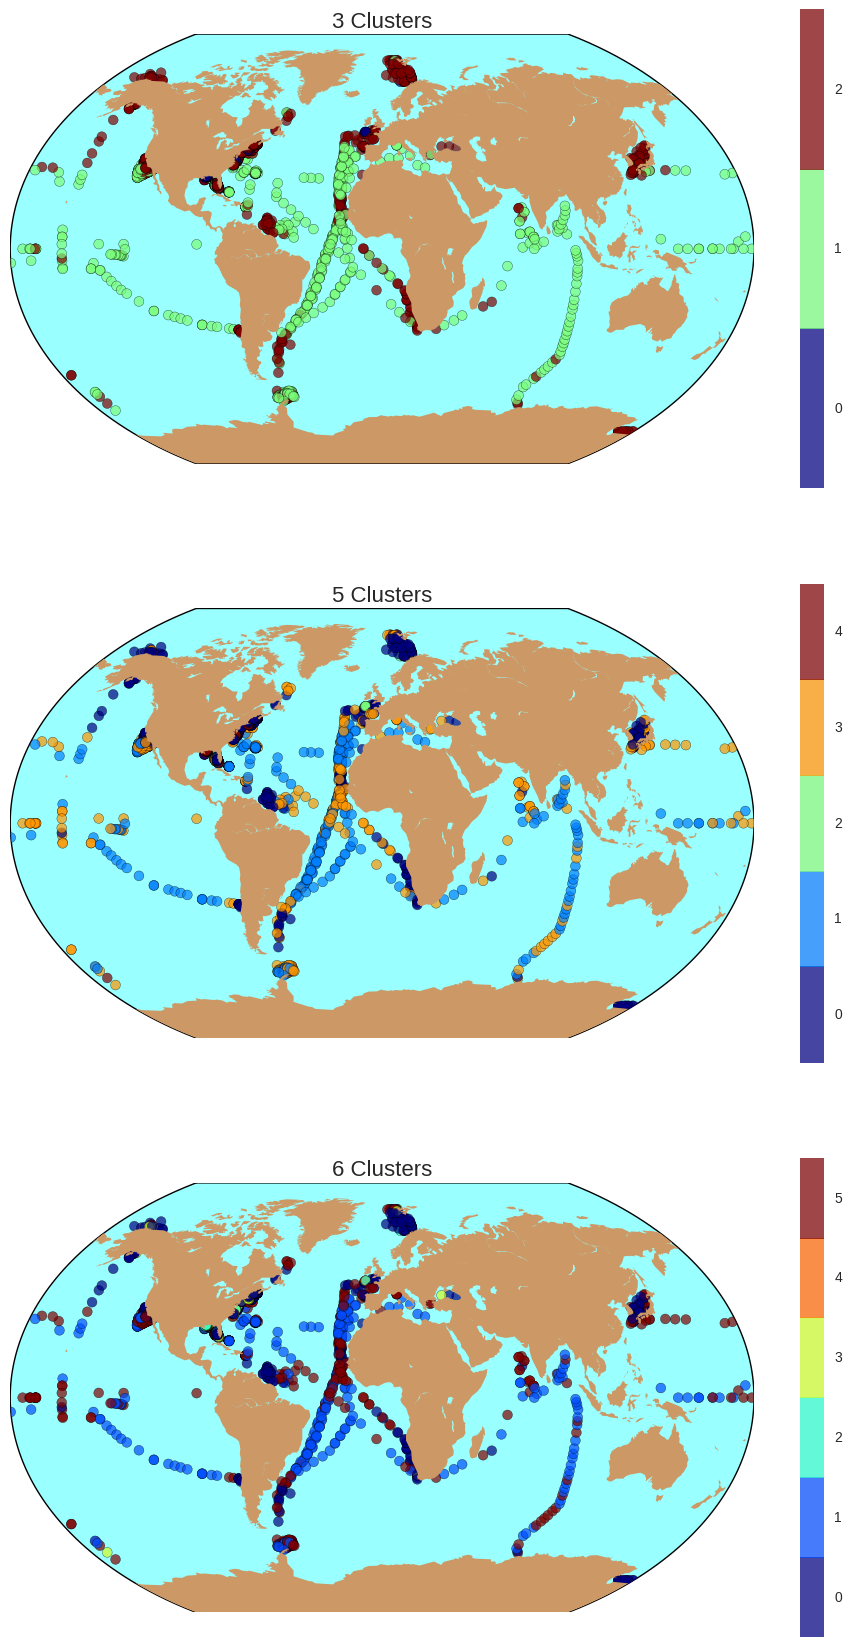

In [26]:
fig,axs=pl.subplots(nrows=3,figsize=(12,21))
for ax,clnum in zip(axs,clusterNums):
    
    cmJet = pl.get_cmap('jet',clnum )
#    mappable = pl.cm.ScalarMappable(cmap=cmJ)
    m = Basemap(projection='kav7',lon_0=0,ax=ax)
    x,y=m(dfnew.lon.values,dfnew.lat.values)
    m.drawmapboundary(fill_color='#99ffff')
    m.fillcontinents(color='#cc9966',lake_color='#99ffff')
    bounds = NP.arange(clnum+1)
    loc=bounds+0.5
    norm = BN(boundaries=bounds, ncolors=cmJet.N)
    sc = m.scatter(x,y,50,marker='o',c=dfnew['%d-cluster' % clnum],cmap=cmJet,alpha=0.7,norm=norm);
    ax.set_title('%d Clusters' % clnum, fontsize=16)
    cb = pl.colorbar(sc, ax=ax,)
    cb.set_ticks(loc)
    cb.set_ticklabels(bounds)

The clustering appears somewhat coherent. In the case of the 3-cluster partition, clusters #0 is consistently observed in coastal waters; cluster #1 appears mostly in what one might consider oceanic waters; cluster #2 seems more often associated with boundary currents.

Similar, though more nuanced observations can be made with the 5- and 6-cluster partition. Any meaningful conclusions however would require more information about the specific sampling locations. One such data that is available; chlorophyll *a*. 

Next, I plot chlorophyll with respect to cluster label for each of partitions selected.Here the notches in the boxplot indicate a 95% confidence interval around the median (horizontal line *inside* the box). If the notches between two boxes don't overlap, I'll assume they are significantly different.
In the 3-cluster partition, there's a significant difference in chlorophyll between cluster #1 and the other two clusters. This distinction agrees with the spatial distribution of each label.  In the 5- and 6-cluster schemes, while such distinctions do occur, many of the boxes are overlapping, suggesting that chlorophyll *a* concentration is insufficient to tease out the significance of each cluster. Here, further interpretation would benefit from additional information about the samples assigned to each cluster.

*Edit* -- smarter people reminded me that Rrs(555) could be a quick and dirty diagnostic for sediment loading... Relevant boxplots accompany the ones described above for chl.

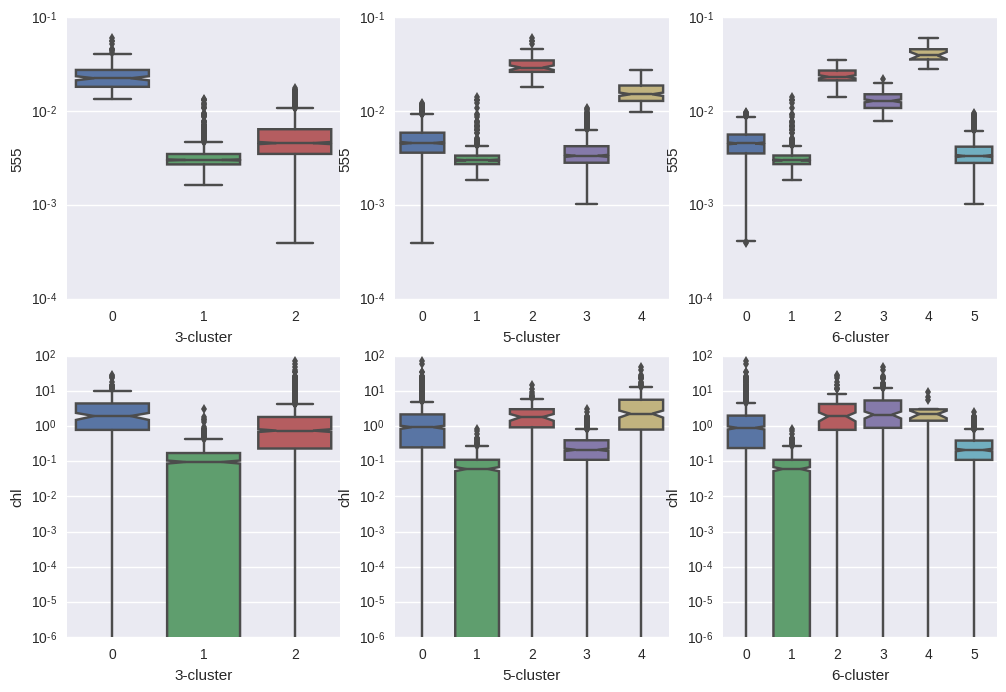

In [24]:
f,axs = pl.subplots(ncols=3, nrows=2,figsize=(12,8))
for i,(ax, clnum) in enumerate(zip(axs.ravel(),clusterNums*2)):
    if i<= 2:
        SB.boxplot(x='%d-cluster' % clnum, y=555, data=dfnew, ax=ax,notch=True) 
        ax.set_ylim((1e-4, 1e-1)) 
    else:
        SB.boxplot(x='%d-cluster' % clnum, y='chl', data=dfnew, ax=ax,notch=True)
        ax.set_ylim((1e-6, 1e2))
    ax.set_yscale('log')

In [34]:
print(dfnew.loc[:,'3-cluster'].value_counts())
print(dfnew.loc[:, '5-cluster'].value_counts())
print(dfnew.loc[:, '6-cluster'].value_counts())

2    1405
1     831
0     168
Name: 3-cluster, dtype: int64
0    982
3    674
1    462
4    218
2     68
Name: 5-cluster, dtype: int64
0    939
5    667
1    459
3    216
2    102
4     21
Name: 6-cluster, dtype: int64


The Rrs(555) data does indeed show clusters significantly separating from each other where they were overlapping in chlorophyll distribution; particularly for the 5- and 6-cluster partitions.

In this post, I attempted to reproduce the results of a fuzzy logic clustering study (Moore *et al*., 2001), using a simpler technique; namely k-means clustering. I also used more Rrs bands as initial input. However the data reduction step by extracting the principal components reduce the number of features to 2. These become the input to the clustering step. By running post-clustering diagnostics I selected three clustering partitions; 3-, 5- and 6- clustering partitions. Moore *et al*. (2001) claim a 6-cluster partition to be the more optimal selection. While this overlap is encouraging, more work is needed to determine whether this is a reasonable scheme. One of the problems may be that the dataset is not very well balanced, with an inherent sampling bias to certaint water types, making some clusters difficult to identify. Furthermore, using apparent optical properties may not be the best way to characterize a water sample. Inherent optical properties that more directly reflect seawater properties may be more appropriate as features for categorizing water types. Since however, the goal of this post was simply to illustrate the application of clustering to real world data, I will stop here. But feel free to pick up the thread.

Happy hacking!